In [2]:
import numpy as np
from numpy.core.defchararray import startswith

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Standard lib
from getpass import getpass

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc
from dl.helpers.utils import convert

#astropy
import astropy.units as u
from astropy.visualization.wcsaxes.frame import EllipticalFrame
from astropy.wcs import WCS
from astropy.table import Table
from astropy.table import QTable
from astropy.utils.data import download_file
from astropy.io import fits
from astropy.visualization import make_lupton_rgb
from astropy.coordinates import SkyCoord

from pyvo.dal import sia

import warnings  
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning) # to quiet Astropy warnings

from mocpy import MOC

from ipyaladin import Aladin

from sidecar import Sidecar

%matplotlib inline

In [55]:
#token = ac.login(input("Enter user name: (+ENTER) "),getpass("Enter password: (+ENTER) "))
ac.whoAmI()

'bmerino95'

Open Sidedcar view

In [3]:
aladin = Aladin()
with Sidecar(title="aladin_output"):
    display(aladin)

Establish url to DECam DR9 data

In [5]:
# nsa images
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/des_dr2"
svc_des_dr2 = sia.SIAService(DEF_ACCESS_URL)

Define area to look for data

In [7]:
# #This cell gives good results.
# #I am going to copy the cell below with different coordinates
# ra = 38.3934 # in degrees
# dec = -39.0453 # in degrees
# fov = .25 # in degrees
# imgTable_des_dr2 = svc_des_dr2.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).to_table()

In [48]:
ra = 76.9272 # in degrees
dec = -37.5157 # in degrees
fov = .25 # in degrees
imgTable_des_dr2 = svc_des_dr2.search((ra,dec), (fov/np.cos(dec*np.pi/180), fov), verbosity=2).to_table()

Preview table

In [9]:
print(len(imgTable_des_dr2))
imgTable_des_dr2

39
33


assoc_id,access_url,access_format,access_estsize,dataproduct_type,dataproduct_subtype,calib_level,dataset_length,im_nsubarrays,im_naxes,im_naxis,im_pixtype,im_wcsaxes,im_scale,obs_title,obs_id,obs_creator_name,obs_collection,obs_creation_type,obs_creation_date,facility_name,instrument_name,obs_bandpass,obs_datasource,proposal_id,obs_publisher_did,obs_release_date,preview,target_name,target_class,s_ra,s_dec,s_fov,s_region,s_calib_status,s_resolution,em_min,em_max,em_resolution,em_res_power,t_min,t_max,t_exptime,t_resolution,o_ucd,o_unit,pol_states,object,airmass,project_code,magzero,prodtype,seeing,fwhm,fileset_id,exptime,photflag,proctype,date_obs,mjd_obs,elliptic
,,,bytes,,,,,,,,,,deg,,,,,,,,,,,,,,,,,deg,deg,deg,deg,,arcsec,m,m,m,,d,d,s,s,,,,,,,,,,,,,,,,,
object,object,object,int32,object,object,int64,int64,int32,int32,object,object,object,object,object,object,object,object,object,object,str1,object,object,object,object,object,object,object,object,object,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
des_dr2,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2&siaRef=DES0507-3749_r4939p01_Y.fits.fz&extn=1&POS=76.9272,-37.5157&SIZE=0.3151843861307306,0.25",image/fits,168409,,,3,0,0,2,[10000 10000],,,[0.26296],,des_dr2,,DES DR2,archival,,,DECam,Y,,,ivo://datalab.noirlab/vo#ivoa_des_dr2.siav1:ivo://datalab.noao/des_dr2/DES0507-3749_r4939p01_Y.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2&siaRef=DES0507-3749_r4939p01_Y.fits.fz&extn=1&POS=76.9272,-37.5157&SIZE=0.3151843861307306,0.25&preview=true",,,76.7677,-37.8185,--,,,--,1130.0,1130.0,--,--,--,--,--,--,,,,DES0507-3749,0,DES DR2,30,image,0,0,,540,,Stack,,56615.32473164,0
des_dr2,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2&siaRef=DES0507-3749_r4939p01_Y.fits.fz&extn=2&POS=76.9272,-37.5157&SIZE=0.3151843861307306,0.25",image/fits,168409,,,3,0,0,2,[10000 10000],,,[0.26296],,des_dr2,,DES DR2,archival,,,DECam,Y,,,ivo://datalab.noirlab/vo#ivoa_des_dr2.siav1:ivo://datalab.noao/des_dr2/DES0507-3749_r4939p01_Y.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2&siaRef=DES0507-3749_r4939p01_Y.fits.fz&extn=2&POS=76.9272,-37.5157&SIZE=0.3151843861307306,0.25&preview=true",,,76.7677,-37.8185,--,,,--,1130.0,1130.0,--,--,--,--,--,--,,,,DES0507-3749,0,DES DR2,30,image,0,0,,540,,Stack,,56615.32473164,0
des_dr2,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2&siaRef=DES0507-3749_r4939p01_Y.fits.fz&extn=3&POS=76.9272,-37.5157&SIZE=0.3151843861307306,0.25",image/fits,168409,,,3,0,0,2,[10000 10000],,,[0.26296],,des_dr2,,DES DR2,archival,,,DECam,Y,,,ivo://datalab.noirlab/vo#ivoa_des_dr2.siav1:ivo://datalab.noao/des_dr2/DES0507-3749_r4939p01_Y.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2&siaRef=DES0507-3749_r4939p01_Y.fits.fz&extn=3&POS=76.9272,-37.5157&SIZE=0.3151843861307306,0.25&preview=true",,,76.7677,-37.8185,--,,,--,1130.0,1130.0,--,--,--,--,--,--,,,,DES0507-3749,0,DES DR2,30,image,0,0,,540,,Stack,,56615.32473164,0
des_dr2,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2&siaRef=DES0507-3749_r4939p01_Y_nobkg.fits.fz&extn=1&POS=76.9272,-37.5157&SIZE=0.3151843861307306,0.25",image/fits,168409,,,3,0,0,2,[10000 10000],,,[0.26296],,des_dr2,,DES DR2,archival,,,DECam,Y,,,ivo://datalab.noirlab/vo#ivoa_des_dr2.siav1:ivo://datalab.noao/des_dr2/DES0507-3749_r4939p01_Y_nobkg.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2&siaRef=DES0507-3749_r4939p01_Y_nobkg.fits.fz&extn=1&POS=76.9272,-37.5157&SIZE=0.3151843861307306,0.25&preview=true",,,76.7677,-37.8185,--,,,--,1130.0,1130.0,--,--,--,--,--,--,,,,DES0507-3749,0,DES DR2,30,image,0,0,,540,,Stack,,56615.32473164,0
des_dr2,"https://datalab.noirlab.edu/svc/cutout?col=des_dr2&siaRef=DES0507-3749_r4939p01_Y_nobkg.fits.fz&extn=2&POS=76.9272,-37.5157&SIZE=0.3151843861307306,0.25",image/fits,168409,,,3,0,0,2,[10000 10000],,,

Create a filter to select only the rows with prodtype=image

In [10]:
sel_des_dr2 = (imgTable_des_dr2['prodtype'] == 'image') & (imgTable_des_dr2['proctype'] == 'Stack')

Apply the filter to the table

In [11]:
row_des_dr2 = imgTable_des_dr2[sel_des_dr2]
print(len(row_des_dr2))

In [14]:
#Image 1
row_1 = imgTable_des_dr2[sel_des_dr2][0]
url_1 = row_1['access_url'] # get the download URL
filename_1 = download_file(url_1,cache=True,show_progress=False,timeout=120)
hdu_1 = fits.open(filename_1)[0]
image_1 = hdu_1.data
wcs_1 = WCS(hdr_1)

In [15]:
#Image 2
row_2 = imgTable_des_dr2[sel_des_dr2][3]
url_2 = row_2['access_url'] # get the download URL
filename_2 = download_file(url_2,cache=True,show_progress=False,timeout=120)
hdu_2 = fits.open(filename_2)[0]
image_2 = hdu_2.data
wcs_2 = WCS(hdr_2)

In [16]:
#Image 3
row_3 = imgTable_des_dr2[sel_des_dr2][6]
url_3 = row_3['access_url'] # get the download URL
filename_3 = download_file(url_3,cache=True,show_progress=False,timeout=120)
hdu_3 = fits.open(filename_3)[0]
image_3 = hdu_3.data
wcs_3 = WCS(hdr_3)

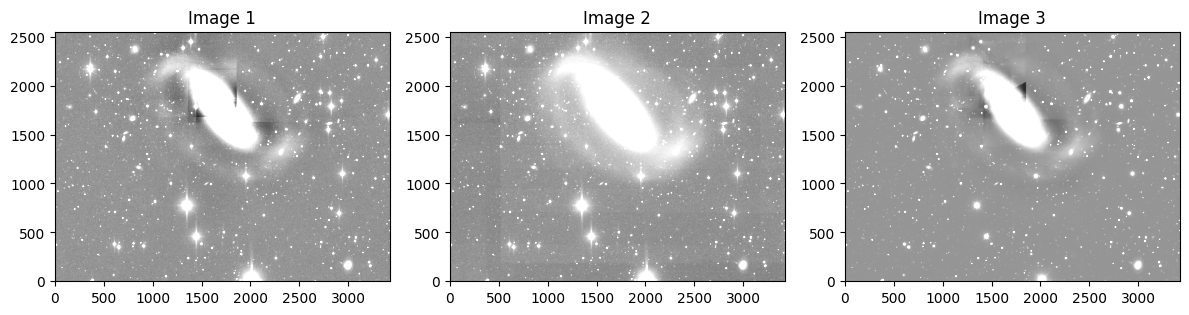

In [39]:
#Preview images
fig,ax = plt.subplots(1,3,figsize=(12,10))

#image 1
ax[0].set_title('Image 1')
im1 = ax[0].imshow(image_1,origin='lower',cmap='Greys_r',vmin=-100,vmax=100)
#plt.colorbar(im1, ax=ax[0])

#image 2
ax[1].set_title('Image 2')
im2 = ax[1].imshow(image_2,origin='lower',cmap='Greys_r',vmin=-100,vmax=100)
#plt.colorbar(im2, ax=ax[1])

#image 3
ax[2].set_title('Image 3')
im3 = ax[2].imshow(image_3,origin='lower',cmap='Greys_r',vmin=-100,vmax=100)
#plt.colorbar(im3, ax=ax[2])

plt.tight_layout()
plt.show()

In [32]:
#Add Image_1 to Aladin
aladin.add_fits(url_1,name='image_1',opacity=1.0,colormap='red')

#Add image_2 to Aladin
aladin.add_fits(url_2,name='image_2',opacity=0.5,colormap='green')

#Add image_2 to Aladin
aladin.add_fits(url_3,name='image_3',opacity=0.25,colormap='blue')

In [35]:
#Center Aladin on the target
target_coord = SkyCoord(ra*u.deg,dec*u.deg)
aladin.target = target_coord

In [88]:
sql = '''SELECT ra, dec, mag_auto_g, mag_auto_i, mag_auto_r, mag_auto_y, mag_auto_z, random_id
            FROM des_dr2.main 
            WHERE Q3C_RADIAL_QUERY(ra,dec,{0},{1},{2})
'''.format(ra, dec, fov/4)
df = qc.query(sql=sql, fmt='pandas')
df

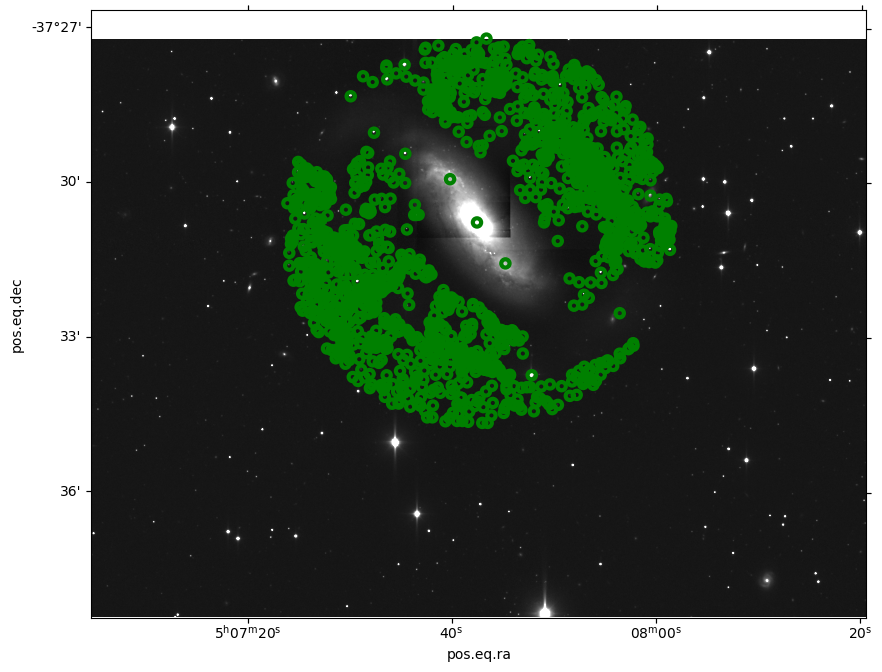

In [90]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=wcs_1)
ax.imshow(image_1, cmap='gray', vmin=image_1.min(), vmax=image_1.min()+(image_1.max()-image_1.min())/100.)
ax.scatter(df['ra'], df['dec'], transform=ax.get_transform('icrs'),
           edgecolor='green', facecolor='none', linewidths=3)
plt.show()

In [92]:
t = Table.from_pandas(df)
t

ra,dec,mag_auto_g,mag_auto_i,mag_auto_r,mag_auto_y,mag_auto_z
float64,float64,float64,float64,float64,float64,float64
76.862265,-37.548456,24.580706,23.572527,23.803978,24.144035,23.54314
76.861412,-37.547703,25.584675,23.551886,24.407204,22.72687,23.211908
76.86035,-37.545463,24.089396,21.635565,22.902134,21.16886,21.120733
76.861957,-37.543341,99.0,25.490347,25.54277,99.0,24.248413
76.855722,-37.541547,23.495234,22.680729,23.103203,23.817982,22.333414
76.854894,-37.540416,23.582125,20.900738,21.673477,20.18439,20.384008
76.858765,-37.542331,26.542238,24.69394,25.527782,99.0,24.995115
76.860565,-37.542761,25.09784,23.172012,23.872185,22.209406,23.348011
76.859942,-37.541441,24.938103,23.86077,24.572603,99.0,23.69898


In [94]:
aladin.add_table(
    t,
    shape='circle',
    source_size=15,
    color='lightblue')